In [1]:
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from actual import actual_effect
from IWLS import IWLS, adaptive_IWLS
from first_order import first_order, adaptive_first_order
from margin import margin

from target import target_value
from utility import data_generation

In [2]:
n = 50
d = 2
k = 5
seeds = [1, 21, 41, 61, 81, 2, 22, 42, 62, 82, 3, 23, 43, 63, 83, 4, 24, 44, 64, 84]
covs = [0.5, 1.0, 2.0, 5.0]

targets = ["probability", "abs_probability", "test_loss", "abs_test_loss", "avg_abs_test_loss", "abs_avg_test_loss"]

target = targets[1]

methods = ["IWLS", "Adaptive IWLS", "Margin-based", "First-order", "Adaptive First-order"]
num_methods, num_covs, num_seeds = len(methods), len(covs), len(seeds)

In [3]:
def read_actual_ranks(file_content):
    general_ranks = re.findall(r'Actual rank: (\d+)', file_content)
    result = {
        "IWLS": int(general_ranks[0]),
        "Adaptive IWLS": int(general_ranks[1]),
        "Margin-based": min(int(general_ranks[2]), int(general_ranks[3])),
        "First-order": int(general_ranks[4]), 
        "Adaptive First-order": int(general_ranks[5])
    }
    return result

def read_best_k_subset(file_path):
    # Initialize an empty list to store the best k subset
    best_k_subset = []

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Use regular expressions to find and extract the best k subset
    pattern = re.compile(fr'size {k}: \[([\d\s]+)\]')
    for line in lines:
        match = pattern.search(line)
        if match:
            # Extract numbers from the matched group and convert to a list of integers
            numbers_str = match.group(1)
            best_k_subset = list(map(int, numbers_str.split()))

            # Break the loop once the information is found
            break

    return best_k_subset

# ratios w.r.t. ground-truth
def ratio_ratio_per_seed_cov(seed, cov, target):
    X_train, y_train, X_test, y_test = data_generation(n, d, cov, seed, target=target)
    
    original_value = target_value(X_train, y_train, X_test, y_test, target=target)
    
    ind_n, ind_p = margin(X_train, y_train)
    
    scores = np.array([
        actual_effect(X_train, y_train, X_test, y_test, read_best_k_subset(f'results/target={target}/n={n}_d={d}_k={k}/s={seed}_cov={cov}.txt'), original_value, target=target), 
        actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target), 
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_first_order(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target)
    ])
    
    ratio = {
        "IWLS": scores[1] / scores[0],
        "Adaptive IWLS": scores[2] / scores[0],
        "Margin-based": scores[3] / scores[0],
        "First-order": scores[4] / scores[0],
        "Adaptive First-order": scores[5] / scores[0],
    }
    
    return ratio

# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks, weights=[5, 4, 3, 2, 1]):
    num_methods, num_experiments = ranks.shape

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(ranks[:, experiment_idx])

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = weights[rank]
            
    total_weighted_borda_count = weighted_borda_count.sum(axis=1)
    ranked_methods_weighted = np.argsort(total_weighted_borda_count)[::-1]
    
    print(f"\nWeighted Borda Count Rankings (target={target}):")
    for rank, method_idx in enumerate(ranked_methods_weighted):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {total_weighted_borda_count[method_idx]}")

    return total_weighted_borda_count

# ranks.shape = (num_methods, num_experiments)
def hitting_rate(ranks, rank_range=(1, 1)):
    num_methods, num_experiments = ranks.shape

    hitting_rates = np.zeros(num_methods, dtype=float)

    for method_idx in range(num_methods):
        total_hits = 0
        for experiment_idx in range(num_experiments):
            rank = ranks[method_idx, experiment_idx]

            if rank_range[1] == rank_range[0]:
                total_hits += 1 if rank == rank_range[0] else 0
            else:
                total_hits += 1 if rank in range(rank_range[0], rank_range[1] + 1) else 0

        hitting_rates[method_idx] = total_hits / num_experiments

    ranked_methods_hitting = np.argsort(hitting_rates)[::-1]

    # Display hitting rates
    print(f"\nHitting Rates (range={rank_range}, target={target}):")
    for rank, method_idx in enumerate(ranked_methods_hitting):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {hitting_rates[method_idx]}")

    return hitting_rates

# ratios.shape = (num_methods, num_experiments)
def average_ratio(ratios):
    avg_ratios = ratios.mean(axis=1)
    
    # Rank methods based on average ratios
    ranked_methods_avg_ratio = np.argsort(avg_ratios)[::-1]

    # Display the ranking based on weighted Borda count scores
    print(f"\nAverage Ratios (w.r.t. ground-truth) Rankings (target={target}):")
    for rank, method_idx in enumerate(ranked_methods_avg_ratio):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {avg_ratios[method_idx]}")

    return avg_ratios

In [6]:
def plot_result(metric="ratio"):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

    for target_idx, target in enumerate(targets):
        print(f"Target: {target}")
        rank_array = np.zeros((num_seeds, num_covs, num_methods), dtype=int)

        # Process each file and populate the array
        for seed_idx, seed in enumerate(seeds):
            for cov_idx, cov in enumerate(covs):
                file_path = f'results/target={target}/n={n}_d={d}_k={k}/s={seed}_cov={cov}.txt'
                with open(file_path, 'r') as file:
                    file_content = file.read()
                    actual_ranks = read_actual_ranks(file_content)
                    # Populate the array
                    for method_idx, method_name in enumerate(methods):
                        rank_array[seed_idx, cov_idx, method_idx] = actual_ranks.get(method_name, 0)  # Default to 0 if method not found

        ratio_array = np.zeros((num_seeds, num_covs, num_methods), dtype=float)
        # Process each seed and covariance and populate the array
        for seed_idx, seed in enumerate(seeds):
            for cov_idx, cov in enumerate(covs):
                ratio = ratio_ratio_per_seed_cov(seed, cov, target)
                for method_idx, method_name in enumerate(methods):
                    ratio_array[seed_idx, cov_idx, method_idx] = ratio.get(method_name, 0)  # Default to 0 if method not found

        rank_method_cov_seed = rank_array.swapaxes(0, 2) # method, cov, seed
        ratio_method_cov_seed = ratio_array.swapaxes(0, 2) # method, cov, seed
        rank_cov_method_seed = rank_method_cov_seed.swapaxes(0, 1) # cov, method, seed
        ratio_cov_method_seed = ratio_method_cov_seed.swapaxes(0, 1) # cov, method, seed

        if metric == "Borda":    
            result = np.array(Parallel(n_jobs=50)(delayed(Borda_count)(rank_cov_method_seed[cov_idx]) for cov_idx in range(num_covs)))
        elif metric == "hitting_rate_1":
            result = np.array(Parallel(n_jobs=50)(delayed(hitting_rate)(rank_cov_method_seed[cov_idx], rank_range=(1, 1)) for cov_idx in range(num_covs)))
        elif metric == "hitting_rate_1_10":
            result = np.array(Parallel(n_jobs=50)(delayed(hitting_rate)(rank_cov_method_seed[cov_idx], rank_range=(1, 10)) for cov_idx in range(num_covs)))
        elif metric == "ratio":
            result = np.array(Parallel(n_jobs=50)(delayed(average_ratio)(ratio_cov_method_seed[cov_idx]) for cov_idx in range(num_covs)))
        

        # Plot in the corresponding subplot
        row_idx, col_idx = divmod(target_idx, 3)  # Calculate subplot index
        for method_idx, method_name in enumerate(methods):
            axs[row_idx, col_idx].plot(covs, result[:, method_idx], label=method_name)
            
        axs[row_idx, col_idx].set_title(f'Target={target}')
        axs[row_idx, col_idx].set_xlabel('Covariance')
        axs[row_idx, col_idx].set_ylabel(metric)
        axs[row_idx, col_idx].legend(methods)
        
        axs[row_idx, col_idx].set_xticks(covs)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.suptitle(f'n={n} d={d} k={k}', fontsize=16)

    plt.show()

Target: probability

Weighted Borda Count Rankings (target=abs_probability):
1. Adaptive First-order: 96
2. Adaptive IWLS: 86
3. First-order: 79
4. IWLS: 77
5. Margin-based: 57

Weighted Borda Count Rankings (target=abs_probability):
1. Adaptive IWLS: 92
2. Adaptive First-order: 91
3. First-order: 71
4. IWLS: 70
5. Margin-based: 32

Weighted Borda Count Rankings (target=abs_probability):
1. Adaptive First-order: 99
2. Adaptive IWLS: 96
3. First-order: 79
4. IWLS: 78
5. Margin-based: 34

Weighted Borda Count Rankings (target=abs_probability):
1. Adaptive First-order: 98
2. Adaptive IWLS: 97
3. First-order: 80
4. IWLS: 79
5. Margin-based: 32
Target: abs_probability

Weighted Borda Count Rankings (target=abs_probability):
1. Margin-based: 90
2. Adaptive IWLS: 87
3. Adaptive First-order: 82
4. IWLS: 68
5. First-order: 67

Weighted Borda Count Rankings (target=abs_probability):
1. Adaptive IWLS: 93
2. Adaptive First-order: 86
3. Margin-based: 68
4. First-order: 57
5. IWLS: 50

Weighted Bord

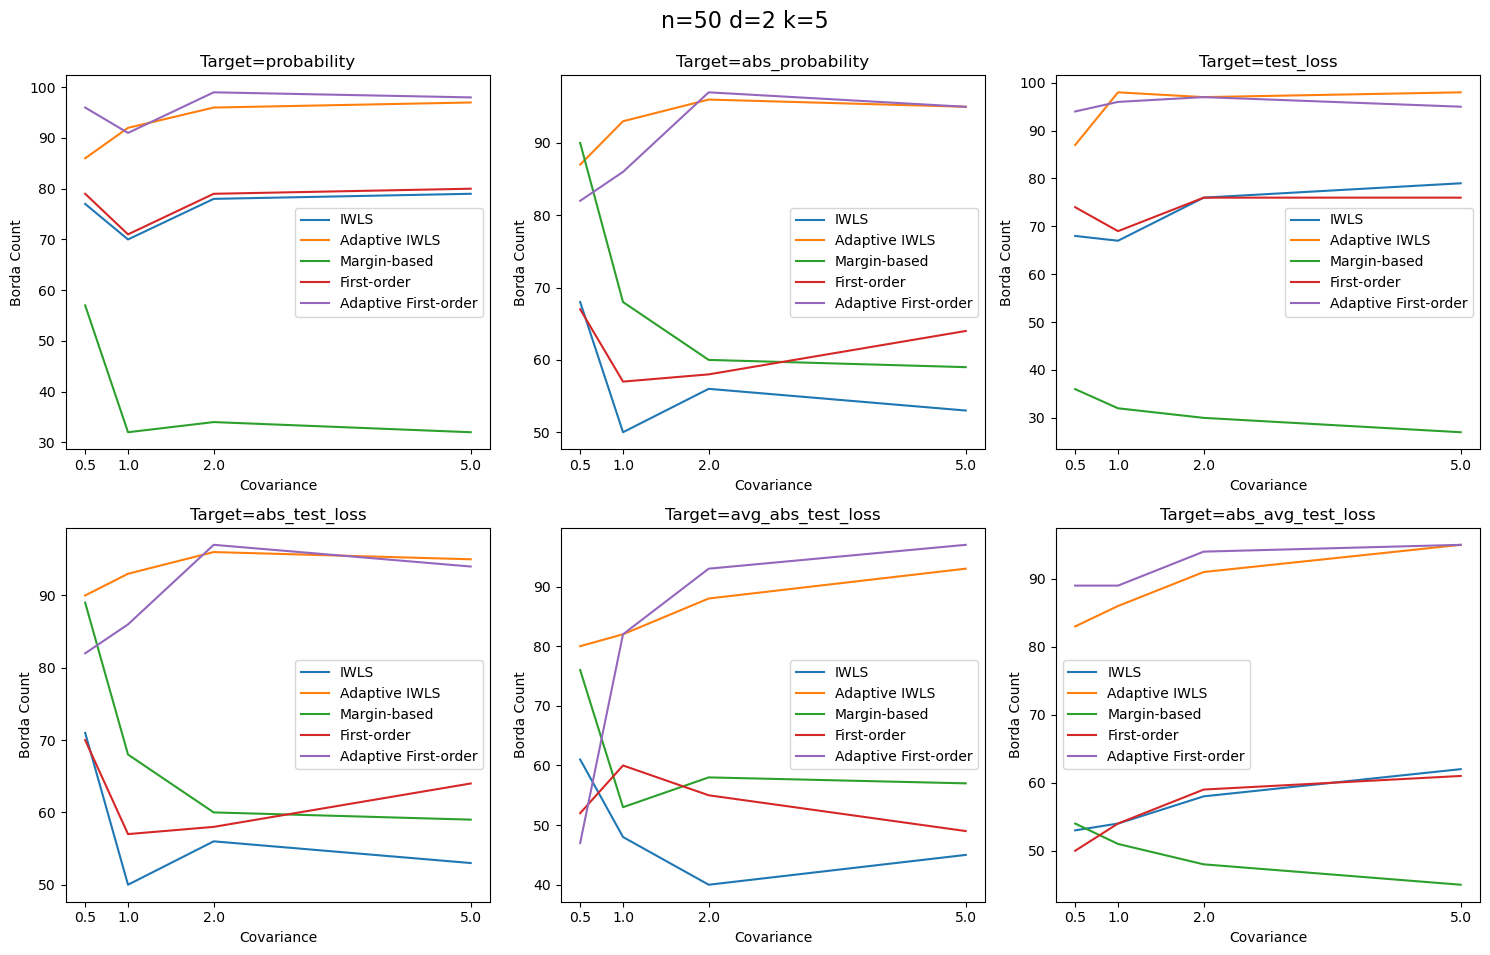

Target: probability

Hitting Rates (range=(1, 1), target=abs_probability):
1. Adaptive First-order: 0.75
2. Adaptive IWLS: 0.65
3. IWLS: 0.45
4. Margin-based: 0.4
5. First-order: 0.4

Hitting Rates (range=(1, 1), target=abs_probability):
1. Adaptive IWLS: 0.6
2. Adaptive First-order: 0.4
3. First-order: 0.15
4. IWLS: 0.15
5. Margin-based: 0.1

Hitting Rates (range=(1, 1), target=abs_probability):
1. Adaptive IWLS: 0.85
2. Adaptive First-order: 0.8
3. First-order: 0.45
4. IWLS: 0.4
5. Margin-based: 0.15

Hitting Rates (range=(1, 1), target=abs_probability):
1. Adaptive First-order: 0.7
2. Adaptive IWLS: 0.65
3. IWLS: 0.35
4. First-order: 0.3
5. Margin-based: 0.1
Target: abs_probability

Hitting Rates (range=(1, 1), target=abs_probability):
1. Margin-based: 0.1
2. Adaptive First-order: 0.05
3. First-order: 0.0
4. Adaptive IWLS: 0.0
5. IWLS: 0.0

Hitting Rates (range=(1, 1), target=abs_probability):
1. Margin-based: 0.15
2. Adaptive First-order: 0.1
3. Adaptive IWLS: 0.1
4. First-order: 0

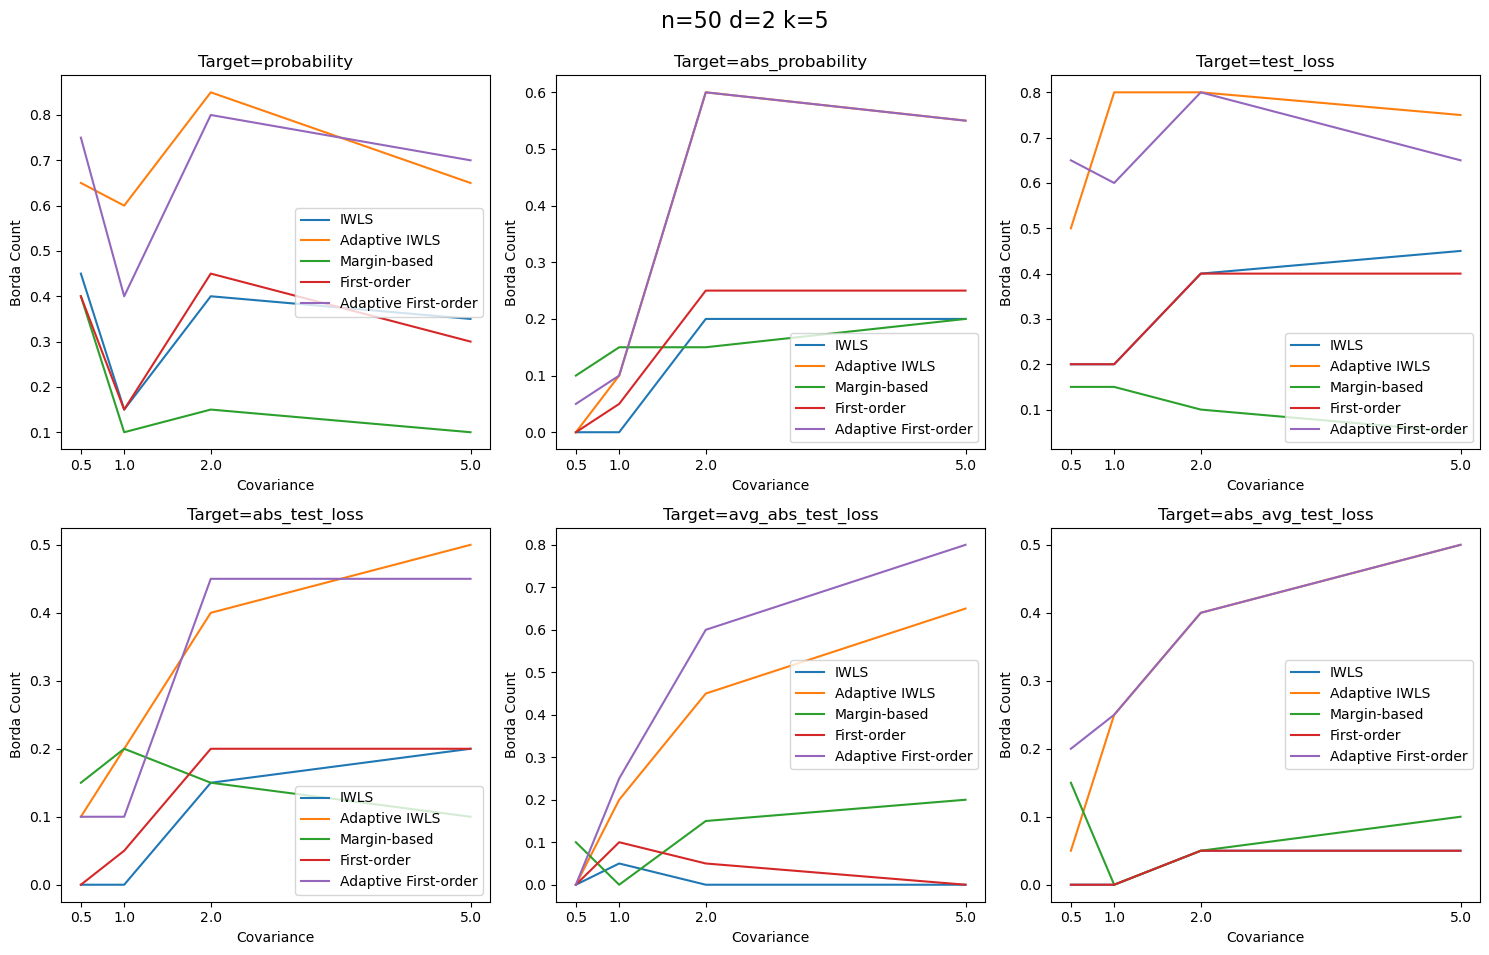

Target: probability

Hitting Rates (range=(1, 10), target=abs_probability):
1. Adaptive First-order: 0.75
2. Adaptive IWLS: 0.65
3. IWLS: 0.55
4. First-order: 0.5
5. Margin-based: 0.4

Hitting Rates (range=(1, 10), target=abs_probability):
1. Adaptive First-order: 0.85
2. Adaptive IWLS: 0.8
3. First-order: 0.75
4. IWLS: 0.7
5. Margin-based: 0.2

Hitting Rates (range=(1, 10), target=abs_probability):
1. Adaptive First-order: 1.0
2. Adaptive IWLS: 1.0
3. First-order: 0.8
4. IWLS: 0.8
5. Margin-based: 0.15

Hitting Rates (range=(1, 10), target=abs_probability):
1. Adaptive First-order: 1.0
2. Adaptive IWLS: 1.0
3. First-order: 0.85
4. IWLS: 0.8
5. Margin-based: 0.3
Target: abs_probability

Hitting Rates (range=(1, 10), target=abs_probability):
1. Margin-based: 0.1
2. Adaptive First-order: 0.05
3. First-order: 0.0
4. Adaptive IWLS: 0.0
5. IWLS: 0.0

Hitting Rates (range=(1, 10), target=abs_probability):
1. Adaptive First-order: 0.2
2. Margin-based: 0.2
3. Adaptive IWLS: 0.2
4. First-order:

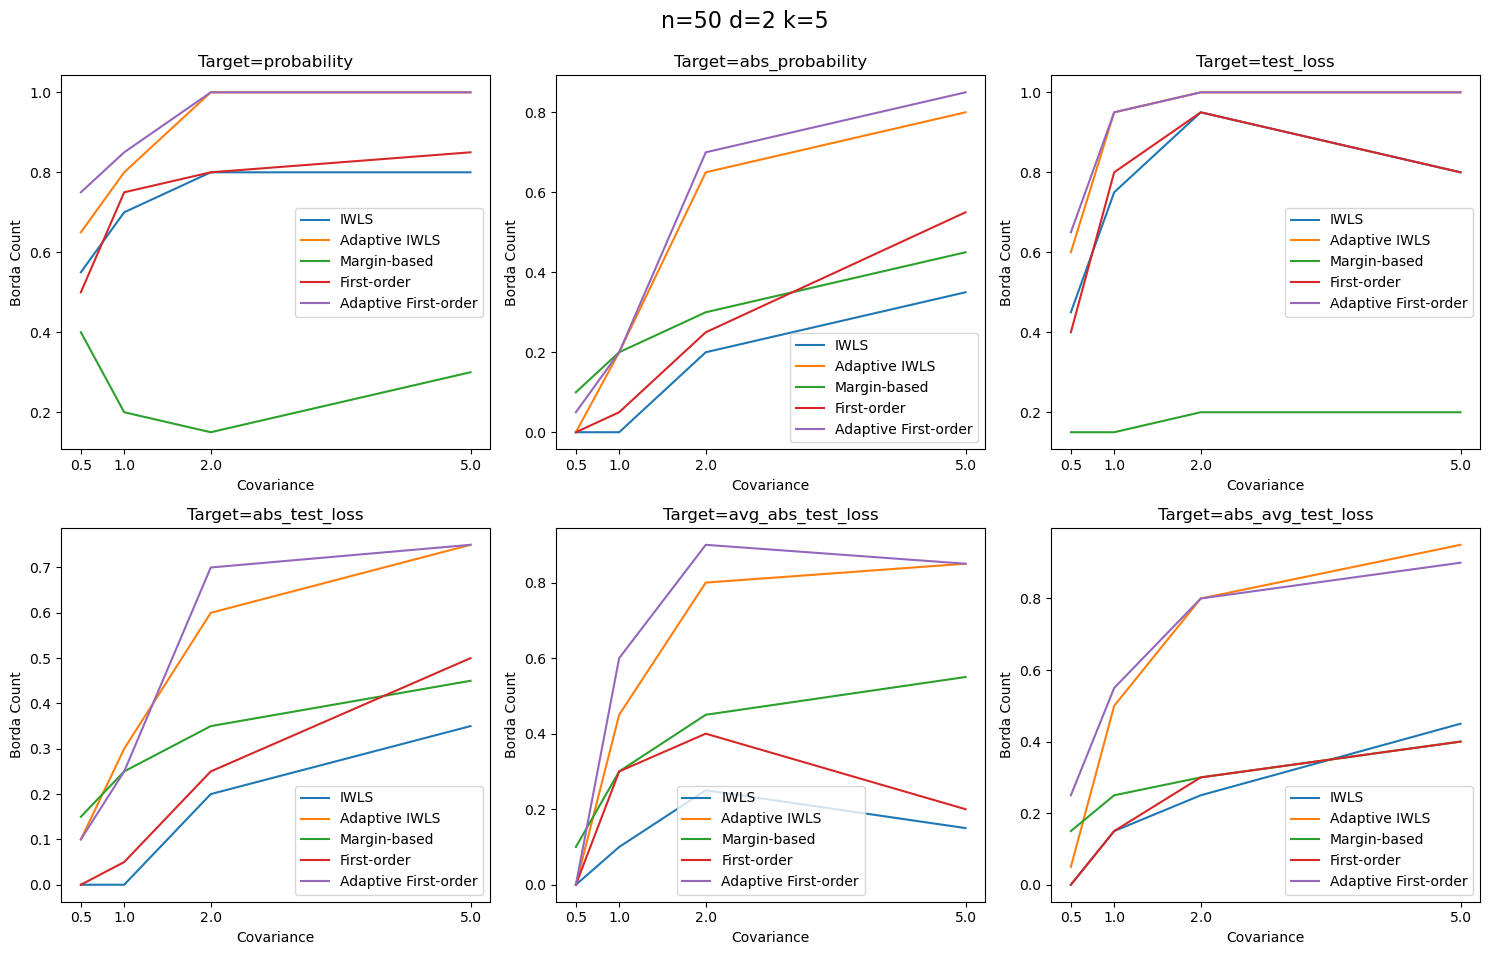

Target: probability

Average Ratios (w.r.t. ground-truth) Rankings (target=abs_probability):
1. Adaptive First-order: 0.9169141974873561
2. Adaptive IWLS: 0.8466108379985334
3. First-order: 0.7300738751110694
4. IWLS: 0.7111374856993944
5. Margin-based: 0.5067985623301599

Average Ratios (w.r.t. ground-truth) Rankings (target=abs_probability):
1. Adaptive IWLS: 0.9054713512249682
2. Adaptive First-order: 0.8992534494110991
3. First-order: 0.862980693396468
4. IWLS: 0.8549374657412805
5. Margin-based: 0.3467319101358031

Average Ratios (w.r.t. ground-truth) Rankings (target=abs_probability):
1. Adaptive First-order: 0.9995228457060488
2. Adaptive IWLS: 0.9981908598047579
3. First-order: 0.9723341773281119
4. IWLS: 0.9722104558247784
5. Margin-based: 0.38813261092617896

Average Ratios (w.r.t. ground-truth) Rankings (target=abs_probability):
1. Adaptive First-order: 0.9933044694585602
2. Adaptive IWLS: 0.9921026061248606
3. First-order: 0.9697001675829163
4. IWLS: 0.9682207031812945
5. M

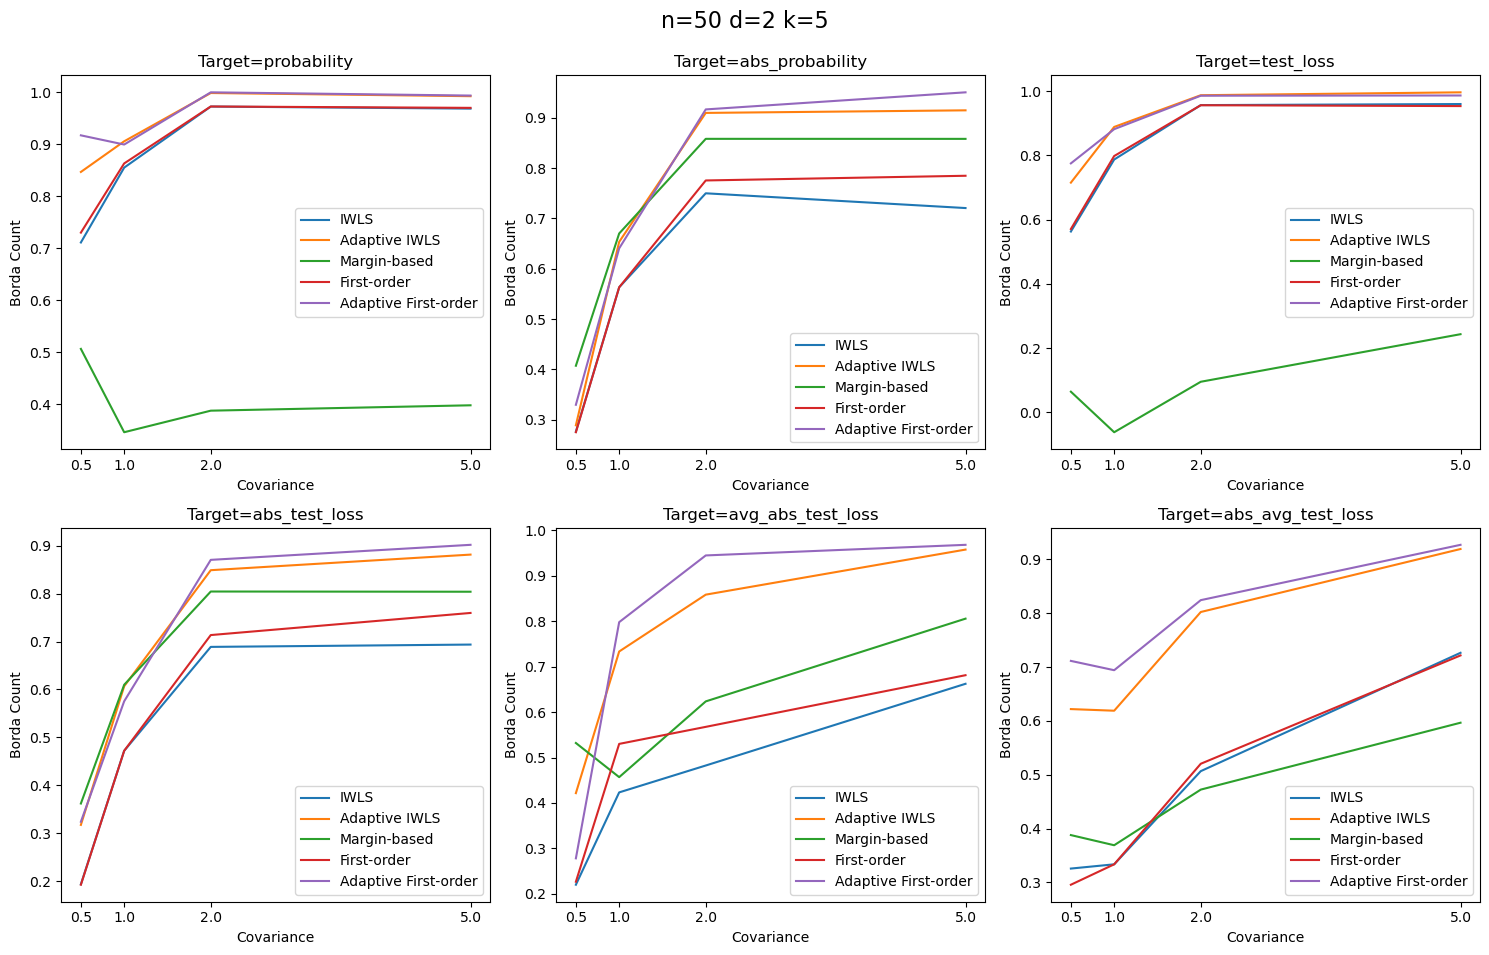

In [7]:
for metric in ["Borda", "hitting_rate_1", "hitting_rate_1_10", "ratio"]:
    plot_result(metric=metric)